In [64]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import ICA
import scipy.signal as signal
import scipy.io as sio
import pandas as pd
from scipy import interpolate

In [65]:
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'qt')

In [66]:
trigger = sio.loadmat("P300_VBT_Trigger_Arr")['data1']
print(trigger.shape)
plt.figure(figsize=(25,10))
plt.plot(trigger[0],trigger[1])
plt.show()

(2, 3580)


In [67]:
data = sio.loadmat("P300_EEG_Data_Arr")['data1']
t = np.arange(trigger.shape[1])
time_stamps = data.shape[1]
new_t = np.linspace(t.min(),t.max(),time_stamps)
trigger_int = interpolate.interp1d(t,trigger,kind = 'cubic')(new_t)
for i in range(len(trigger_int[1])):
    if trigger_int[1][i]<0:
        trigger_int[1][i] = 0
    if trigger_int[1][i]>2:
        trigger_int[1][i] = 2

# print(trigger_int.shape)
trigger_data = np.delete(trigger_int,0,axis=0)
# print(trigger_int.shape)
# print(data.shape)
eegdata = arr = np.concatenate([data, trigger_data], axis=0)
# print(eegdata.shape)


MemoryError: 

In [ ]:
time=data[0,:]
eegdat=eegdata[1:131,:]
n=1000
eegdat.shape
plt.figure(figsize=(25,10))
plt.plot(time,eegdat[129])
plt.show()

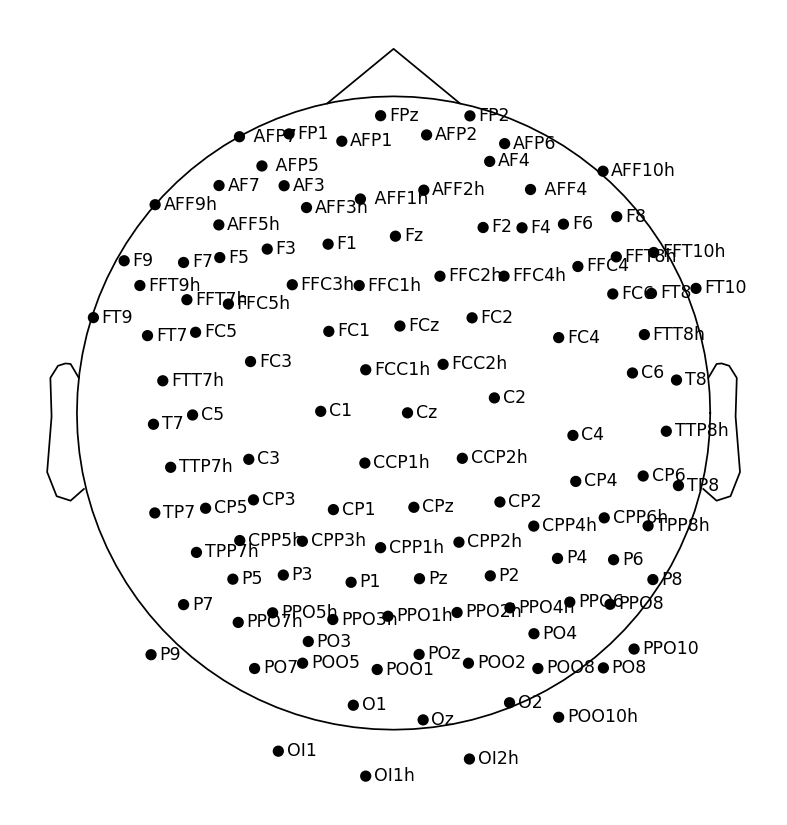

In [ ]:
############################################## Digmontage
mon1=sio.loadmat('128Ch_Montage_IncludingSpacers.mat')
xpos=mon1['Mon']['xposition'][0][0].ravel()
ypos=mon1['Mon']['yposition'][0][0].ravel()
zpos=mon1['Mon']['zposition'][0][0].ravel()
nch=len(xpos)

ch_pos1=np.concatenate((xpos.reshape(nch,1),ypos.reshape(nch,1),zpos.reshape(nch,1)),axis=1)

Ename=mon1['Mon']['electrodename'][0][0].flatten()
Ename2=[]
for i in np.arange(len(Ename)):
    chx=Ename[i][0]
    Ename2=np.append(Ename2,chx)
        
    
Enum=mon1['Mon']['electrodenumber'][0][0].ravel()
#Enum is the electrode number from the electrode box itself

df=pd.DataFrame()
df['xpos']=xpos/n
df['ypos']=ypos/n
df['zpos']=zpos/n
df['ch_names']=Ename2
df['ch_num']=Enum
df2=df.sort_values('ch_num')        

    

######################################################################################
############################################ Modifying df2 with the Einscan DigPoints
######################################################################################

subject= 'P300_EEG_Data_Arr'
sub = subject 
dataframe1 = np.loadtxt("Coordinates_savelfile.txt")
my_file = open("Labels_savedfile.txt", "r")
dataframe2 = my_file.readlines()
imported_labels=[]
for d in dataframe2:
    d=d.replace("\n", "")
    imported_labels.append(d)
my_file.close()

DigPos = t=np.transpose(np.vstack((np.transpose(dataframe1), np.transpose(imported_labels))))
del dataframe1, dataframe2

df_new=pd.DataFrame()

Enum=[]
#nch=len(xpos)
#ch_pos1=np.concatenate((xpos.reshape(nch,1),ypos.reshape(nch,1),zpos.reshape(nch,1)),axis=1)/1000

Ename = DigPos[:,3]
for i in Ename:
    try:   
        #print("working")
        indxOfCh=(df2['ch_names'].to_list().index(i))
        Enum.append(df2['ch_num'].to_list()[indxOfCh])
    except:
        if i =='LPA':
            Enum.append(2)
        if i== 'RPA':
            Enum.append(3)
Enum=np.asarray(Enum, dtype='uint8')
Nz_indx=Ename.tolist().index('Nasion')
Nz_pos=np.array([DigPos[Nz_indx,0],DigPos[Nz_indx,1],DigPos[Nz_indx,2]], dtype='float')/n
DigPos = np.delete(DigPos,Nz_indx , 0)
Ename = np.delete(Ename,Nz_indx , 0)

xpos=np.asarray(DigPos[:,0], dtype='float')
ypos=np.asarray(DigPos[:,1], dtype='float')
zpos=np.asarray(DigPos[:,2], dtype='float')


df=pd.DataFrame()
df['xpos']=xpos/n
df['ypos']=ypos/n
df['zpos']=zpos/n
df['ch_names']=Ename
df['ch_num']=Enum
df2=df.sort_values('ch_num')  
df33 = df.sort_values('ch_num') 


ch_num2=[129]
ch_names2=['Lead1']
df3=pd.DataFrame()
df3['ch_names']=ch_names2
df3['ch_num']=ch_num2

df33=df33.append(df3)



ch_num2=[130]
ch_names2=['STIM']
df3=pd.DataFrame()
df3['ch_names']=ch_names2
df3['ch_num']=ch_num2

df33=df33.append(df3)


df33=df33.sort_values('ch_num')


indxOfCh=(df2['ch_names'].to_list().index('LPA'))
A1=np.array([df2['xpos'].to_list()[indxOfCh],  df2['ypos'].to_list()[indxOfCh]  ,  df2['zpos'].to_list()[indxOfCh]])


indxOfCh=(df2['ch_names'].to_list().index('RPA'))
A2=np.array([df2['xpos'].to_list()[indxOfCh],  df2['ypos'].to_list()[indxOfCh]  ,  df2['zpos'].to_list()[indxOfCh]])

xpos1=df2.iloc[0,0]
ypos1=df2.iloc[0,1]
zpos1=df2.iloc[0,2]

ch_dict={df2.iloc[0,3]:np.array([xpos1,ypos1,zpos1])}

for i in np.arange(df2.shape[0]-1):
    xpos2=df2.iloc[i+1,0]
    ypos2=df2.iloc[i+1,1]
    zpos2=df2.iloc[i+1,2]
    dict1={df2.iloc[i+1,3]:np.array([xpos2,ypos2,zpos2])}
    ch_dict.update(dict1)
    
del ch_dict['LPA']
del ch_dict['RPA']
del ch_dict['AF8']
del ch_dict['F10']
digMon1=mne.channels.make_dig_montage(ch_pos=ch_dict,nasion=Nz_pos, lpa=A1, rpa=A2)
digMon1.plot()
mne.viz.plot_montage(digMon1, show_names=True, kind='topomap', show=True, sphere=None, verbose=None)


In [ ]:
#COnvert numpy array Enname2 into a list ---
#Ename2=Ename2.tolist()
#ch_names=Ename2
ch_names=pd.Series.tolist(df33['ch_names'])
Enum=pd.Series.tolist(df33['ch_num']-1)
#Enum = list(range(0,131))
#Here we subtracted 1 from all the values in Enum because Enum holds exact electrode numbers......
#......But eegdat is an array so it starts from 0. So, one number less than actual electrode num
#-------------------------------------------
eegdat_final=eegdat[Enum,:]
eegdat=eegdat_final
#eegdat2=np.concatenate((eegdat,Trig1200.reshape(1,eegdat.shape[1])))


In [ ]:
#%% Create the data structure
sampling_freq=1200
#ch_names=ch_names.tolist()
#ch_types=['eeg']*1+['misc']*2+['eeg']*125+['ecg']*2+['stim']*1   #misc are our two reference channels
ch_types=['eeg']*1+['misc']*2+['eeg']*78+['eog']+['eeg']*8+['eog']+['eeg']*31+['ecg']*1+['stim']*1   #misc are our two reference channels
info1=mne.create_info(ch_names=ch_names, ch_types=ch_types,sfreq=sampling_freq)  #- this gives error
# to automatically set momtage ------info1.set_montage('standard_1020')
print(info1)
raw_eeg=mne.io.RawArray(eegdat,info1) #################################################
raw_eeg.set_montage(digMon1)#, on_missing='ignore') #on_missing ignores the error thrown by mis
#  raw.plot(scalings='auto', duration=10)
raw_eeg.plot_sensors(ch_type='eeg', show_names=True, to_sphere=True, sphere='eeglab')
SaveRoot= "D:\Sem 6\BCI Lab\Assignements\VBT" + sub +"_raw.fif"

raw_eeg.save(fname=SaveRoot, overwrite='True')
print(sub+"_"+ "is done")
raw_eeg.info


<Info | 7 non-empty values
 bads: []
 ch_names: Cz, LPA, RPA, FPz, Fz, FCz, CPz, Pz, POz, Oz, C1, C5, T7, C2, ...
 chs: 118 EEG, 2 misc, 2 EOG, 1 ECG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 600.0 Hz
 meas_date: unspecified
 nchan: 124
 projs: []
 sfreq: 1200.0 Hz
>
Creating RawArray with float64 data, n_channels=124, n_times=134213
    Range : 0 ... 134212 =      0.000 ...   111.843 secs
Ready.
Overwriting existing file.
Writing D:\Sem 6\BCI Lab\Assignements\VBTP300_EEG_Data_Arr_raw.fif
Closing D:\Sem 6\BCI Lab\Assignements\VBTP300_EEG_Data_Arr_raw.fif
[done]
P300_EEG_Data_Arr_is done


<Info | 8 non-empty values
 bads: []
 ch_names: Cz, LPA, RPA, FPz, Fz, FCz, CPz, Pz, POz, Oz, C1, C5, T7, C2, ...
 chs: 118 EEG, 2 misc, 2 EOG, 1 ECG, 1 Stimulus
 custom_ref_applied: False
 dig: 121 items (3 Cardinal, 118 EEG)
 highpass: 0.0 Hz
 lowpass: 600.0 Hz
 meas_date: unspecified
 nchan: 124
 projs: []
 sfreq: 1200.0 Hz
>

# EEG

---


## Plot the RAW data and view

In [ ]:
raw_eeg.plot(scalings='auto', duration=10)
raw_eeg.info

Using matplotlib as 2D backend.


<Info | 8 non-empty values
 bads: []
 ch_names: Cz, LPA, RPA, FPz, Fz, FCz, CPz, Pz, POz, Oz, C1, C5, T7, C2, ...
 chs: 118 EEG, 2 misc, 2 EOG, 1 ECG, 1 Stimulus
 custom_ref_applied: False
 dig: 121 items (3 Cardinal, 118 EEG)
 highpass: 0.0 Hz
 lowpass: 600.0 Hz
 meas_date: unspecified
 nchan: 124
 projs: []
 sfreq: 1200.0 Hz
>

In [ ]:
raw_eeg_final = raw_eeg.copy().filter(1,100)
raw_eeg_final.plot(scalings='auto', duration=10)
raw_eeg_final.info

# Channels marked as bad:
# ['FP1', 'O2', 'FFC4h', 'TTP7h', 'AFF2h', 'OI1h', ' AFP7']

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 3961 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 118 out of 118 | elapsed:    0.7s finished


<Info | 8 non-empty values
 bads: []
 ch_names: Cz, LPA, RPA, FPz, Fz, FCz, CPz, Pz, POz, Oz, C1, C5, T7, C2, ...
 chs: 118 EEG, 2 misc, 2 EOG, 1 ECG, 1 Stimulus
 custom_ref_applied: False
 dig: 121 items (3 Cardinal, 118 EEG)
 highpass: 1.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 nchan: 124
 projs: []
 sfreq: 1200.0 Hz
>

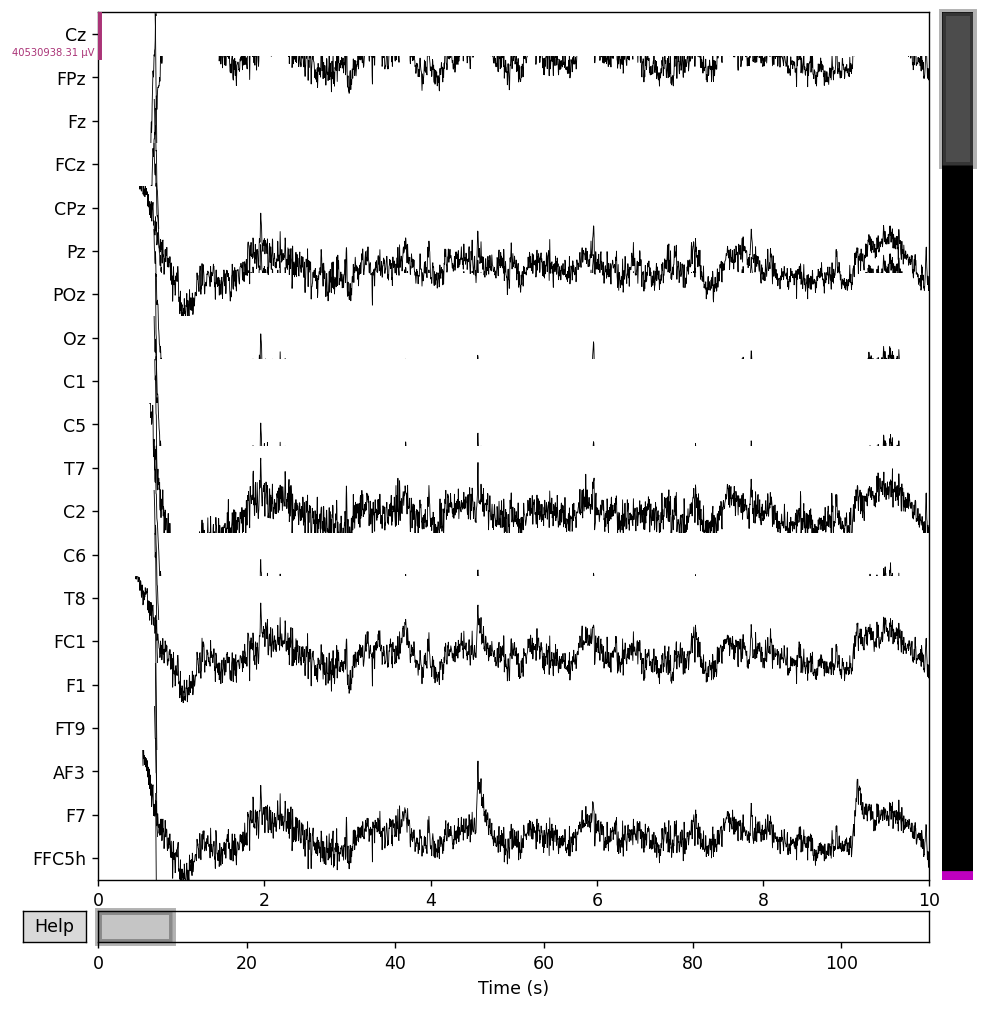

In [ ]:
raw_eeg_final.info['bads'] = ['FP1', 'O2', 'FFC4h', 'TTP7h', 'AFF2h', 'OI1h', ' AFP7']
raw_eeg_final2 = raw_eeg_final.copy().pick_types(meg=False, eeg=True, eog=True,ecg=True, exclude='bads')
raw_eeg_final2.plot(scalings='auto', duration=10)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.707 (s)


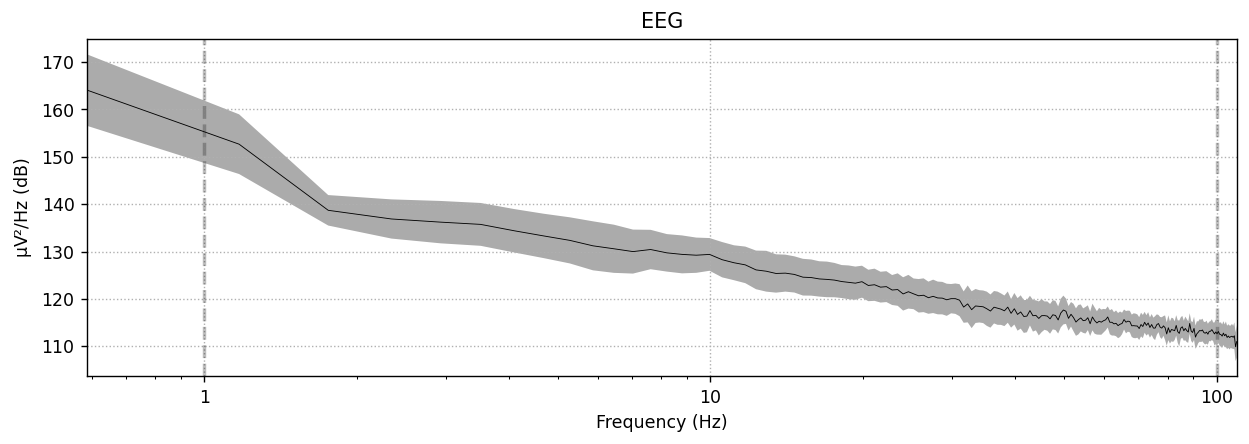

In [ ]:
raw_eeg_final2.plot_psd(average=True, spatial_colors=True, xscale='log', fmin=0.5,fmax=110)

# Run ICA  - plot components and browse

In [ ]:
ica_eeg = ICA(n_components=20, random_state=97)
ica_eeg.fit(raw_eeg_final2) # Run ICA

Fitting ICA to data using 111 channels (please be patient, this may take a while)
Selecting by number: 20 components


<ipython-input-14-2a8c6919ed83>:2: RuntimeWarning: Using n_components=20 (resulting in n_components_=20) may lead to an unstable mixing matrix estimation because the ratio between the largest (1.1e+02) and smallest (5.1e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14
  ica_eeg.fit(raw_eeg_final2) # Run ICA


Fitting ICA took 10.2s.


Method,fastica
Fit,74 iterations on raw data (134213 samples)
ICA components,20
Available PCA components,111
Channel types,eeg
ICA components marked for exclusion,—


In [ ]:
x = ica_eeg.plot_sources(raw_eeg_final) # Plot time series
x = ica_eeg.plot_components() #Plot topographies

Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none


Creating RawArray with float64 data, n_channels=23, n_times=134213
    Range : 0 ... 134212 =      0.000 ...   111.843 secs
Ready.


In [ ]:
# plot power spectrum of components
# ica_eeg.plot_properties(raw_eeg, picks=range(15))

# Drop artefactual components

In [ ]:
raw_eeg.load_data()

ica_eeg.exclude = [0,2,4,5,10,12]  # indices chosen based on various plots above <======

# ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_raw = raw_eeg_final2.copy()
ica_eeg.apply(reconst_raw)

#Raw
raw_eeg_final2.plot(scalings='auto', duration=10)
plt.suptitle('Raw Time series')


#Reconstruced after removing artefactual components
reconst_raw.plot(scalings='auto', duration=10)
plt.suptitle('Cleaned Time series')
plt.show()

raw_eeg.plot_psd(fmax=40)
reconst_raw.plot_psd(fmax=40)
plt.show()

# del reconst_raw


Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 6 ICA components
    Projecting back using 111 PCA components
Channels marked as bad:
none
Channels marked as bad:
none
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.707 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.707 (s)


In [ ]:
raw_eeg = mne.io.read_raw_fif('D:\Sem 6\BCI Lab\Assignements\VBTP300_EEG_Data_Arr_raw.fif', preload=True)

Opening raw data file D:\Sem 6\BCI Lab\Assignements\VBTP300_EEG_Data_Arr_raw.fif...
    Range : 0 ... 134212 =      0.000 ...   111.843 secs
Ready.
Reading 0 ... 134212  =      0.000 ...   111.843 secs...


In [ ]:
events = mne.find_events(raw_eeg, stim_channel='STIM')

Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
915 events found
Event IDs: [1 2]


In [ ]:
event_dict = {'1': 1, '2': 2}
fig = mne.viz.plot_events(events, sfreq=raw_eeg.info['sfreq'],
                          first_samp=raw_eeg.first_samp, event_id=event_dict)
fig.subplots_adjust(right=0.7)  # make room for legend

In [ ]:
epochs = mne.Epochs(raw_eeg_final2, events, event_id = event_dict,tmin=-0.2, tmax=0.7, baseline=(-0.2,-0.05),preload=True)

Not setting metadata
915 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 915 events and 1081 original time points ...
8 bad epochs dropped


In [ ]:
print(epochs)

<Epochs |  907 events (all good), -0.2 - 0.7 sec, baseline -0.2 – -0.05 sec, ~852.9 MB, data loaded,
 '1': 827
 '2': 80>


In [ ]:
print(epochs.event_id)

{'1': 1, '2': 2}


You seem to have overlapping epochs. Some event lines may be duplicated in the plot.


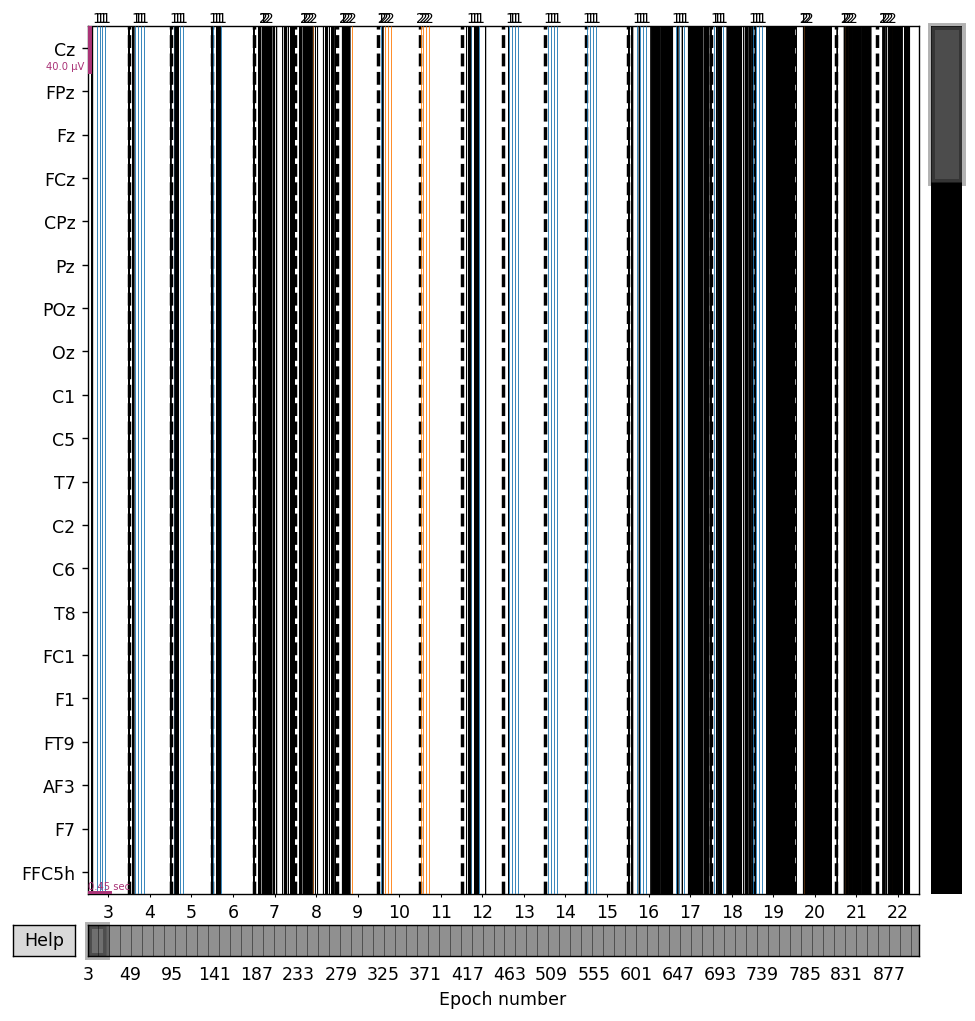

Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [ ]:
epochs.plot(events=events)

In [ ]:
evoked1 = epochs['1'].average()
evoked2 = epochs['2'].average()

In [ ]:
print(f'Epochs baseline: {epochs.baseline}')
print(f'Evoked baseline: {evoked1.baseline}')

Epochs baseline: (-0.2, -0.05)
Evoked baseline: (-0.2, -0.05)


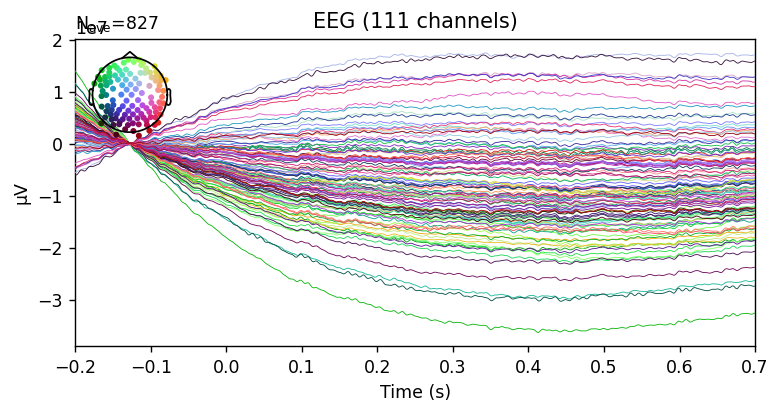

In [ ]:
evoked1.plot()

In [ ]:
print(f'Epochs baseline: {epochs.baseline}')
print(f'Evoked baseline: {evoked2.baseline}')

Epochs baseline: (-0.2, -0.05)
Evoked baseline: (-0.2, -0.05)


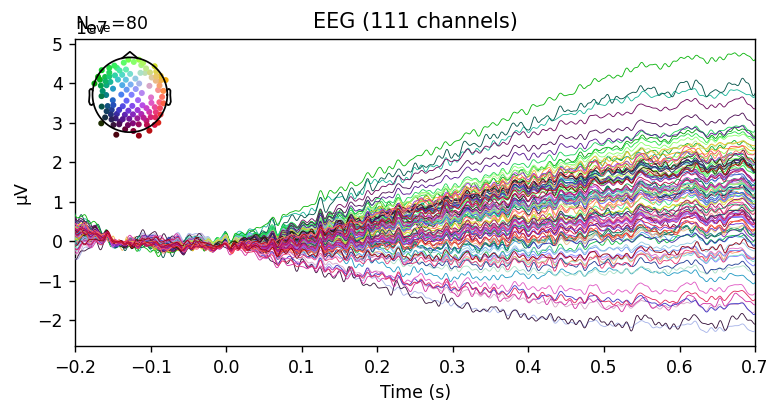

In [ ]:
evoked2.plot()

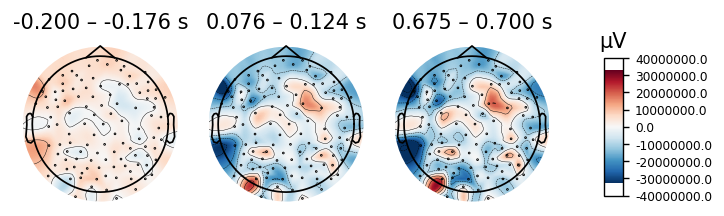

In [ ]:
evoked1.plot_topomap(times=[-0.2, 0.1, 0.7], average=0.05)

No projector specified for this dataset. Please consider the method self.add_proj.


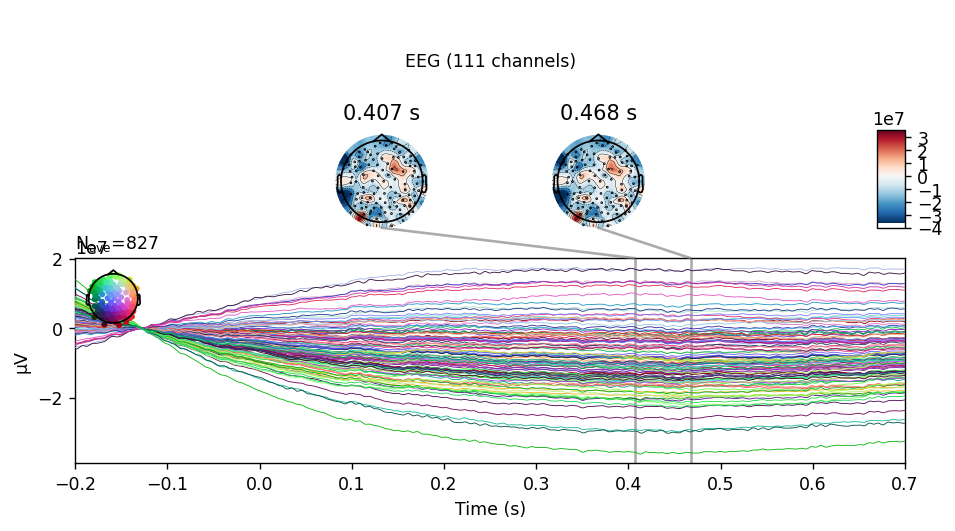

In [ ]:
evoked1.plot_joint()

In [ ]:
for evk in (evoked1,evoked2):
    evk.plot(gfp=True, spatial_colors=True, ylim=dict(eeg=[-12, 12]))

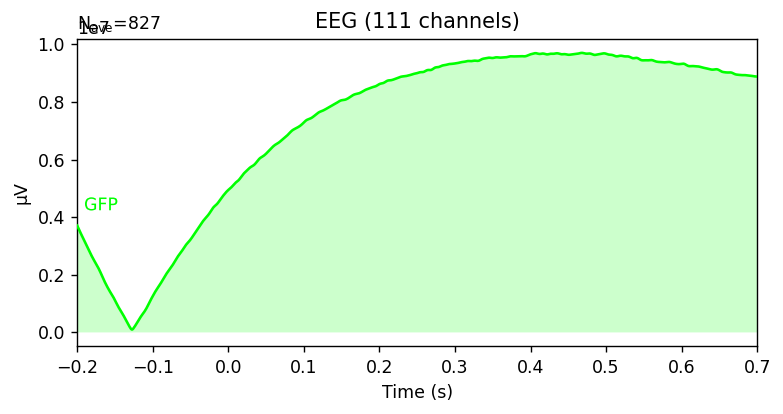

In [ ]:
evoked1.plot(gfp='only')

In [68]:
epochs['1'].plot_image(picks=13)

MemoryError: Unable to allocate 778. MiB for an array with shape (827, 114, 1081) and data type float64

In [1]:
# save evoked data
evoked1.save('D:\Sem 6\BCI Lab\Assignements\VBTP300_EEG_Data_Arr_evoked1.fif')
evoked2.save('D:\Sem 6\BCI Lab\Assignements\VBTP300_EEG_Data_Arr_evoked2.fif')


NameError: name 'evoked1' is not defined